# Try different learning rates

In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [42]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.observations.ar_gaussian_observation import ARGaussianObservation
from ssm_ptc.transformations.linear import LinearTransformation
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

from tqdm import tqdm_notebook as tqdm

import time

In [3]:
import joblib

datasets_processed = joblib.load('/Users/leah/Columbia/courses/19summer/SocialBehavior/tracedata/all_data_3_1')  # a list of length 30, each is a social_dataset

rendered_data = []
for dataset in datasets_processed:
    session_data = dataset.render_trajectories([3,8])  # list of length 2, each item is an array (T, 2). T = 36000
    rendered_data.append(np.concatenate((session_data),axis = 1)) # each item is an array (T, 4)
trajectories = np.concatenate(rendered_data,axis = 0)  # (T*30, 4)

traj29 = rendered_data[29]

# try lr = 0.001

In [7]:
K = 5
D = 4
T = 36000

tran = LinearTransformation(K=K, D=D, lags=1)
observation = ARGaussianObservation(K=K, D=D, M=0, transformation=tran)

model = HMM(K=K, D=D, M=0, observation=observation)

data = torch.tensor(traj29, dtype=torch.float64)

In [19]:
model.log_likelihood(data)

tensor(-927377.7184, dtype=torch.float64,
       grad_fn=<HMMNormalizerCythonBackward>)

In [20]:
num_iters = 5000
pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.001)

losses = []

for i in np.arange(num_iters):

    optimizer.zero_grad()
    
    loss = model.loss(data)
    #loss.backward(retain_graph=True)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().numpy())
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)
        
pbar.close()

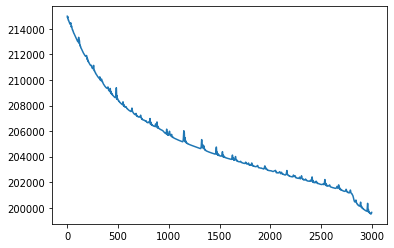

In [25]:
plt.plot(losses[2000:])

# check prediction and reconstruction

In [26]:
z = model.most_likely_states(data)

In [27]:
x_predict_arr = k_step_prediction(model, z, data)

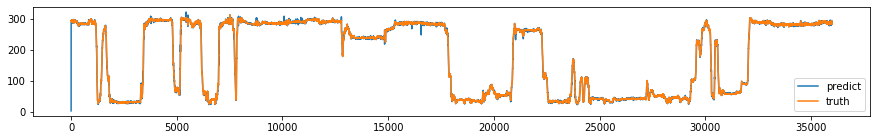

In [28]:
plt.figure(figsize=(15,2))
plt.plot(x_predict_arr[:,0], label='predict')
plt.plot(data[:,0].numpy(), label='truth')
plt.legend()
plt.show()

reconstruction in this way (fixing the whole z-sequence) may not be a good idea.

# sample new data

In [29]:
sample_z, sample_x = model.sample(T)

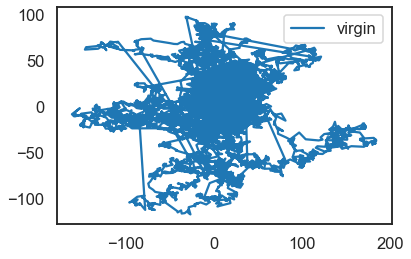

In [110]:
plt.plot(sample_x[:20000,2], sample_x[:20000,3], label='virgin')
#plt.plot(sample_x[:,2], sample_x[:,3], label='mother')
plt.legend()
plt.show()

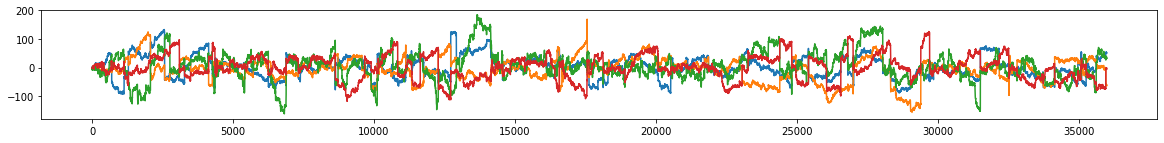

In [32]:
plt.figure(figsize=(20,2))
plt.plot(sample_x[:,0])
plt.plot(sample_x[:,1])
plt.plot(sample_x[:,2])
plt.plot(sample_x[:,3])

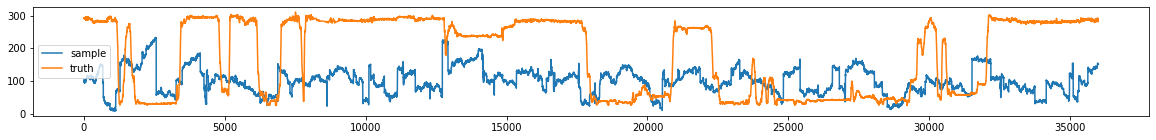

In [36]:
plt.figure(figsize=(20,2))
plt.plot(sample_x[:,0]+100, label='sample')
plt.plot(traj29[:,0], label='truth')
plt.legend()

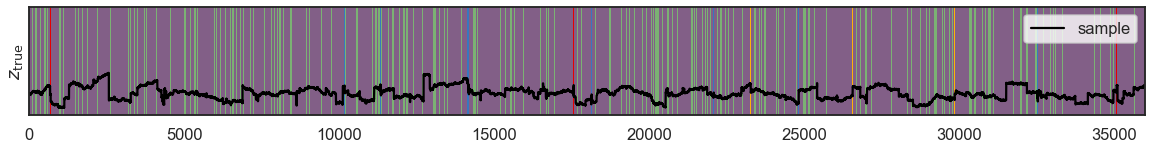

In [55]:
plt.figure(figsize=(20,2))

lim = 1.05 * abs(sample_x[:,0]).max()

plt.imshow(sample_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1, extent=(0, T, -lim, (D)*lim))
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.plot(sample_x[:,0], label='sample', color='black')
#plt.plot(np.diff(traj29[:,0]), label='truth')
plt.legend()

([], <a list of 0 Text yticklabel objects>)

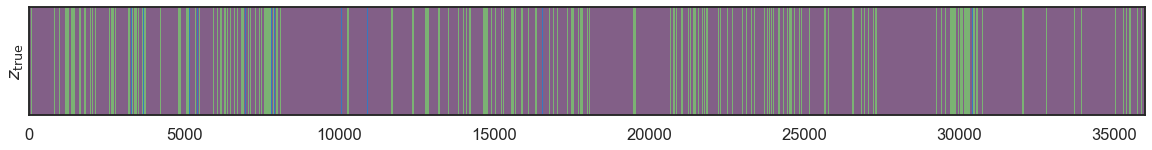

In [43]:
plt.figure(figsize=(20,2))
plt.imshow(z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, T)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

In [44]:
[sum(z == k) for k in range(K)]

[245, 0, 0, 6764, 28991]

In [60]:
np.max(np.diff(traj29[:,0]))

20.32843953371048

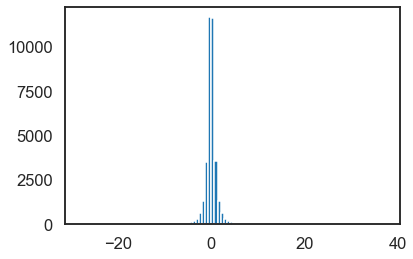

In [70]:
plt.hist(np.diff(traj29[:,3]), bins=100);

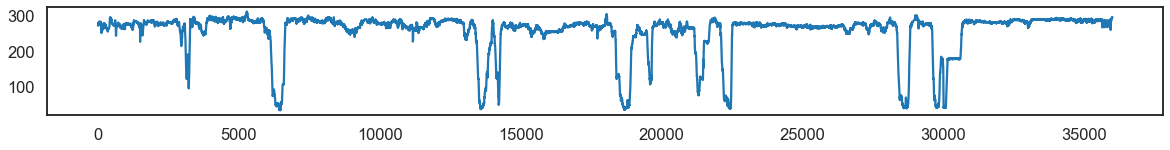

In [105]:
plt.figure(figsize=(20,2))
plt.plot(rendered_data[0][:,0])

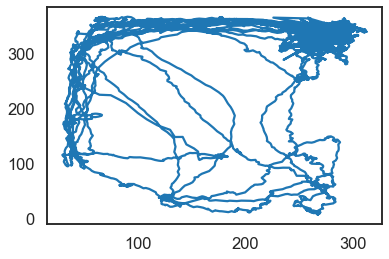

In [97]:
plt.plot(rendered_data[0][:,0], rendered_data[0][:,1])

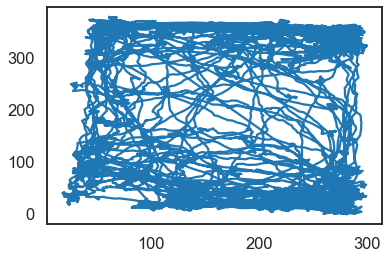

In [98]:
plt.plot(rendered_data[0][:,2], rendered_data[0][:,3])